In [1]:
import tensorflow as tf
import numpy as np
import time
from arc import *
from qutip import *
import matplotlib.pyplot as plt

from quantum_optimal_control.two_qubit.propagator_vl import PropagatorVL
from quantum_optimal_control.toolkits.plotting_helper import *
from quantum_optimal_control.toolkits.plotting_helper.generic_plotter import getStylishFigureAxes
from quantum_optimal_control.toolkits.plotting_helper.plot_plotter import PlotPlotter


2025-03-04 08:47:16.952418: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 08:47:16.954462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 08:47:17.000579: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 08:47:17.001974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 08:47:17.826061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
atom = Rubidium87()

# 1. Intermediate excited state: 6P3/2
n_i = 6
l_i = 1
j_i = 1.5
T_i = atom.getStateLifetime(n_i, l_i, j_i)
Gamma_ig = 1/T_i

Gamma_i1 = 1 * Gamma_ig  # Intermediate (F=3) to 1 state (F=2)
Gamma_i0 = 0 * Gamma_ig  # Intermediate (F=3) to 0 state (F=1) is forbidden

# 2. Decay between hyperfine ground states (from Levine2018)
Gamma_10 = 0.1  # one second

# 3. Rydberg state: 70 S1/2
n_r = 70
l_r = 0
j_r = 0.5
# Total lifetime: Accounting for blackbody stimulation of Rydberg state to nearby states: (see Levin2018)
# Total lifetime is blackbody plus radiative: 1/T_rtotal = 1/T_rBB + 1/T_rRadiative
T_rTot = atom.getStateLifetime(n_r, l_r, j_r,
                                    temperature=300, includeLevelsUpTo=n_r + 50)
# Radiative lifetime: decay to other ground state (so at 0 K temp)
T_rRad = atom.getStateLifetime(n_r, l_r, j_r, temperature=0)

# radiative transition from rydberg to intermediate
T_ri = 1/atom.getTransitionRate(n_r, l_r, j_r,
                                        n_i, l_i, j_i, temperature=0)
T_rgp = 1/(1/T_rRad - 1/T_ri)  # radiative transition from rydberg to dark ground states

# Black body stimulated: Transition from rydberg to nearby rydberg
T_rBB = 1/(1/T_rTot - 1/T_rRad)

# Set decay rate to each state
Gamma_ri = 1/T_ri
Gamma_rrp = 1/T_rBB  # r to r' (r prime)
Gamma_rgp = 1/T_rgp  # rydberg to g' (ground prime dark states)
Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp  # Total decay from Rydberg
Gamma_rd = Gamma_rrp + Gamma_rgp

Gammas = [Gamma_10, Gamma_i1, Gamma_ri, Gamma_rd]

In [4]:
V_int = 2 * np.pi * 10 * 1e6  # Example value, keep as a single value, not an array.
tau = 324e-9       #example value for the current case          # Example value, derived from the optimal_tau array.
Delta_i = 2 * np.pi * -35.7 * 1e6      # Example value, derived from the optimal_Delta_1 array


# Define V_array for later use in plotting parameters or robustness checks
V_array = np.array([2 * np.pi * 10 * 1e6]) # Example array mirroring what might have been loaded.
# Recalculating optimal_tau and optimal_Delta_1 for consistency, mimicking the original logic

# For this example, we assume a simplified "optimization" process where we select pre-known optimal values.
# In a real scenario, you might have a function to calculate these.  This is to replace the data loading.
optimal_tau = np.array([tau])  # Using the pre-set tau
optimal_Delta_1 = np.array([Delta_i]) # Using the pre-set Delta_i

print(f'V_int: {V_array / (2 * np.pi * 1e6)} MHz')
print(f'Optimal tau: {optimal_tau * 1e9} ns')
print(f'Optimal Delta_1: {optimal_Delta_1 / (2 * np.pi * 1e6)} MHz')


######Parameters level :######################

# Set system parameters:
Rabi_i = 2 * np.pi * 100 * 1e6  # coupling state 1 to i
Rabi_r = 2 * np.pi * 100 * 1e6  # coupling state i to r
del_total = 0

# Set time grid:
t_0 = 0  # Initial time
t_f = 2 * tau
nt = 1000  # number of time points
pad = int(0.03 * nt)  # set number of padding points (for zeroes during pulse)
delta_t = (t_f - t_0)/(nt + 2 * pad)  # time difference between steps
tlist = np.linspace(0, t_f, nt + 2 * pad)

# Set bandwidth of pulse: sets largest frequency component in pulse
f_std = 50 * 1e6  # (using 20 ns rise time)

# Set number of basis functions for the control amplitudes
input_dim = 10  # (number of Gaussian modes)

# Set number of iterations in the optimization:
num_iters = 500
# Set learn rate for optimizer:
learn_rate = 0.02

# set random seed
seed = 42
tf.random.set_seed(seed=seed)

print(pad * delta_t * 1e9)


V_int: [10.] MHz
Optimal tau: [324.] ns
Optimal Delta_1: [-35.7] MHz
18.339622641509436


2025-03-04 08:47:20.973144: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


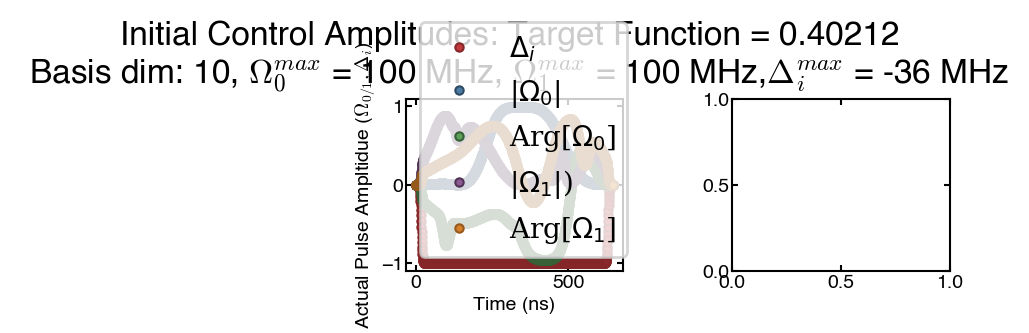

In [5]:
# Set propagator
propagatorVL = PropagatorVL(
    input_dim, nt, pad, f_std, delta_t, del_total, V_int, Delta_i, Rabi_i, Rabi_r,
    Gammas
)

# Set initial control amplitude guess seeding:
numb_ctrl_amps = 5  # number of control amplitudes (Delta_i, Rabi_iX2, Rabi_rX2)

# Gaussian amplitudes:
propagatorVL.ctrl_amplitudes_a.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], -1, 1, dtype=tf.float64)
)
# Initialize Gaussian peaks to be Rabi_r before Rabi_i:
# (Keep Delta uniform random)
# Gaussian centers:
propagatorVL.ctrl_amplitudes_b[:, 0].assign(
    tf.random.uniform([input_dim], -1, 1, dtype=tf.float64)
)
# Set half of the Gaussian centers to order the pulses Rabi_r then Rabi_i:
# Set magntidues of Rabi:
#Rabi_i: magnitude
propagatorVL.ctrl_amplitudes_b[:, 1:2].assign(
    tf.random.uniform([input_dim, 1], -0.5, 0.5, dtype=tf.float64)
)
#Rabi_r: magnitude
propagatorVL.ctrl_amplitudes_b[0:int(input_dim/2), 3:4].assign(
    tf.random.uniform([int(input_dim/2), 1], -1, -0.5, dtype=tf.float64)
)
# Set half of the Gaussian centers to order the pulses Rabi_i then Rabi_r
#Rabi_r: magnitude
propagatorVL.ctrl_amplitudes_b[int(input_dim/2):input_dim, 3:4].assign(
    tf.random.uniform([int(input_dim/2), 1], 0.5, 1, dtype=tf.float64)
)

# Set phases of Rabi: (uniformaly)
#Rabi_i: phase
propagatorVL.ctrl_amplitudes_b[:, 2:3].assign(
    tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
)
#Rabi_r: phase
propagatorVL.ctrl_amplitudes_b[:, 4:5].assign(
    tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
)

# Gaussian widths:
propagatorVL.ctrl_amplitudes_c.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], 0, 0.5, dtype=tf.float64)
)

# Find infidelity using propagator
initial_infidelity = propagatorVL.target()

# Plot initial guess pulses:
labels = [
    '$\Delta_i$', '|$\Omega_0$|', 'Arg[$\Omega_0$]',
    '|$\Omega_1$|)', 'Arg[$\Omega_1$]'
]

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # Original matplotlib plotting
fig, (ax1, ax2) = getStylishFigureAxes(1, 2)  # Use the stylish plotting functions
ind = 0
physical_amplitudes_initial = propagatorVL.return_physical_amplitudes().numpy()


# Initial Pulse Plotting
for amplitude in tf.transpose(physical_amplitudes_initial):
    PlotPlotter(fig, ax1, tlist/1e-9, amplitude, style={'label': labels[ind]}).draw()
    ind +=1

ax1.set_title(
    'Initial Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
$\Delta_i^{max}$ = %.0f MHz'
    % (initial_infidelity, input_dim, Rabi_i/(2 * np.pi * 1e6), Rabi_r/(2 * np.pi * 1e6),
       Delta_i/(2 * np.pi * 1e6)
       ), fontsize=12
)
ax1.set_ylabel('Actual Pulse Ampltidue ($\Omega_{0/1}, \Delta_i$)')
ax1.set_xlabel('Time (ns)')
ax1.legend()

In [6]:
# Optimize pulse with gradient accent:
optimizer = tf.keras.optimizers.Adam(learn_rate)


@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        infidelity = propagatorVL.target()
    gradients = tape.gradient(infidelity, [propagatorVL.ctrl_amplitudes_a,
                              propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c])
    optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes_a,
                              propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c]))
    return propagatorVL.target()


# Measure run time:
start = time.time()

print('step 0: Figure of Merit = %2.5f' %
      (initial_infidelity))

best_infidelity = 1
steps = range(num_iters)
for step in steps:
    current_infidelity = optimization_step()
    if (step + 1) % 3 == 0:
        print('step%2d: Figure of Merit = %2.5f' %
              (step + 1, current_infidelity))
    # keep best result:
    if current_infidelity < best_infidelity:
        best_infidelity = current_infidelity

physical_amplitudes_final = propagatorVL.return_physical_amplitudes().numpy()

# Measure run time:
end = time.time()
print('Run Time: %2.4f seconds' % (end-start))

# Plot final results of control amplitudes
ind = 0
for amplitude in physical_amplitudes_final.T:
    PlotPlotter(fig, ax2, tlist/1e-9, amplitude, style={'label': labels[ind], 'linewidth': 0.75, 'marker': ''}).draw()
    ind += 1

ax2.set_title(
    'Final Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
$\Delta_i^{max}$ = %.0f MHz'
    % (current_infidelity, input_dim, Rabi_i/(2 * np.pi * 1e6), Rabi_r/(2 * np.pi * 1e6),
       Delta_i/(2 * np.pi * 1e6)
       ), fontsize=12
)
ax2.set_ylabel('Actual Pulse Ampltidue ($\Omega_{0/1}, \Delta_i$)')
ax2.set_xlabel('Time (ns)')
ax2.legend()

print('Best figure of merit: %2.5f' % best_infidelity)

plt.show()

step 0: Figure of Merit = 0.40212
step 3: Figure of Merit = 0.26983
step 6: Figure of Merit = 0.20757
step 9: Figure of Merit = 0.19385
step12: Figure of Merit = 0.19286
step15: Figure of Merit = 0.19132
step18: Figure of Merit = 0.19119
step21: Figure of Merit = 0.18883
step24: Figure of Merit = 0.17891
step27: Figure of Merit = 0.11052
step30: Figure of Merit = 0.06871
step33: Figure of Merit = 0.04814
step36: Figure of Merit = 0.04730
step39: Figure of Merit = 0.02278
step42: Figure of Merit = 0.01572
step45: Figure of Merit = 0.01347
step48: Figure of Merit = 0.01108
step51: Figure of Merit = 0.00899
step54: Figure of Merit = 0.00782
step57: Figure of Merit = 0.00722
step60: Figure of Merit = 0.00671
step63: Figure of Merit = 0.00636
step66: Figure of Merit = 0.00617
step69: Figure of Merit = 0.00602
step72: Figure of Merit = 0.00589
step75: Figure of Merit = 0.00581
step78: Figure of Merit = 0.00575
step81: Figure of Merit = 0.00568
step84: Figure of Merit = 0.00563
step87: Figure

In [7]:
# %%
# Test robustness:
# Set percentage of original amplitude:
percent_amp = 1

# Set actual pulse amplitudes (tanh(ctrl_amplitudes))
Rabi_i_Pulse_real_opt = percent_amp * physical_amplitudes_final[:, 1] * \
    np.cos(np.pi * physical_amplitudes_final[:, 2])
# interpolated data for time evolution
Rabi_i_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_real_opt)
Rabi_i_Pulse_imag_opt = percent_amp * physical_amplitudes_final[:, 1] * \
    np.sin(np.pi * physical_amplitudes_final[:, 2])
# interpolated data for time evolution
Rabi_i_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_imag_opt)

Rabi_r_Pulse_real_opt = percent_amp * physical_amplitudes_final[:, 3] * \
    np.cos(np.pi * physical_amplitudes_final[:, 4])
Rabi_r_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_real_opt)
Rabi_r_Pulse_imag_opt = percent_amp * physical_amplitudes_final[:, 3] * \
    np.sin(np.pi * physical_amplitudes_final[:, 4])
Rabi_r_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_imag_opt)

Delta_i_opt = percent_amp * physical_amplitudes_final[:, 0]
Delta_i_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_i_opt)

# Convert real and imaginary parts of Rabi frequency into amplitude and phase
Rabi_i_amplitude = np.sqrt(Rabi_i_Pulse_opt_real_S(tlist)**2 + Rabi_i_Pulse_opt_imag_S(tlist)**2)
Rabi_i_phase = np.pi * physical_amplitudes_final[:, 2]
Rabi_r_amplitude = np.sqrt(Rabi_r_Pulse_opt_real_S(tlist)**2 + Rabi_r_Pulse_opt_imag_S(tlist)**2)
Rabi_r_phase = np.pi * physical_amplitudes_final[:, 4]

In [8]:
def nLevelAtomBasis(n):  # Set basis for n level atom

    states = []
    for n_l in range(0, n):
        states.append(basis(n, n_l))

    return states

def QTHamiltonian(argsME5lvl):
    psi0, psi_orth, V_int, Rabi_i_max, Rabi_r_max, Rabi_i_Pulse_Re, Rabi_r_Pulse_Re, Rabi_i_Pulse_Im, \
        Rabi_r_Pulse_Im, Delta_i_Pulse, Delta_i_max, del_total, Gammas = argsME5lvl

    # set dimension of Hilbert space:
    dim = 5

    # Set operators:
    g_0, g_1, i, r, dark = nLevelAtomBasis(dim)  # basis are ground

    sig_00 = g_0 * g_0.dag()
    sig_11 = g_1 * g_1.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_01 = g_0 * g_1.dag()
    sig_1i = g_1 * i.dag()
    sig_dr = dark * r.dag()
    sig_ir = i * r.dag()

    # Set single qubit hamiltonian parts:
    H_SQ_del = - del_total * sig_rr
    H_SQ_Delta_i = - Delta_i_max * sig_ii
    H_SQ_Rabi_i_re = - 1/2 * Rabi_i_max * (sig_1i + sig_1i.dag())
    H_SQ_Rabi_i_im = - 1j/2 * Rabi_i_max * (sig_1i - sig_1i.dag())
    H_SQ_Rabi_r_re = - 1/2 * Rabi_r_max * (sig_ir + sig_ir.dag())
    H_SQ_Rabi_r_im = - 1j/2 * Rabi_r_max * (sig_ir - sig_ir.dag())

    # Set two qubit static terms
    H_TQ_del_total = tensor(identity(dim), H_SQ_del) + tensor(H_SQ_del, identity(dim))
    H_TQ_0 = H_TQ_del_total + V_int * tensor(sig_rr, sig_rr)

    # Set single photon detunings:
    H_TQ_Delta = tensor(identity(dim), H_SQ_Delta_i) + tensor(H_SQ_Delta_i, identity(dim))

    # Real part
    # Set drive 1:(use same power on each qubit))
    H_TQ_Rabi_i_re = tensor(H_SQ_Rabi_i_re, identity(dim)) + \
        tensor(identity(dim), H_SQ_Rabi_i_re)
    # Set second qubit drive 1:
    H_TQ_Rabi_r_re = tensor(H_SQ_Rabi_r_re, identity(dim)) + \
        tensor(identity(dim), H_SQ_Rabi_r_re)

    # Imaginary part
    H_TQ_Rabi_i_im = tensor(H_SQ_Rabi_i_im, identity(dim)) + \
        tensor(identity(dim), H_SQ_Rabi_i_im)
    # Set second qubit drive 1:
    H_TQ_Rabi_r_im = tensor(H_SQ_Rabi_r_im, identity(dim)) + \
        tensor(identity(dim), H_SQ_Rabi_r_im)

    H = [H_TQ_0, [H_TQ_Delta, Delta_i_Pulse], [H_TQ_Rabi_i_re, Rabi_i_Pulse_Re],
         [H_TQ_Rabi_i_im, Rabi_i_Pulse_Im], [H_TQ_Rabi_r_re, Rabi_r_Pulse_Re],
         [H_TQ_Rabi_r_im, Rabi_r_Pulse_Im]
         ]
    return H

def Mesolve_5lvl_t(time, argsME5lvl, output_states=False, options=None):
    psi0, psi_orth, V_int, Rabi_i_max, Rabi_r_max, Rabi_i_Pulse_Re, Rabi_r_Pulse_Re, Rabi_i_Pulse_Im, \
        Rabi_r_Pulse_Im, Delta_i_Pulse, Delta_i_max, del_total, Gammas = argsME5lvl

    H = QTHamiltonian(argsME5lvl)

    # set dimension of Hilbert space:
    dim = 5

    # Set operators:
    g_0, g_1, i, r, dark = nLevelAtomBasis(dim)  # basis are ground

    sig_00 = g_0 * g_0.dag()
    sig_11 = g_1 * g_1.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_01 = g_0 * g_1.dag()
    sig_1i = g_1 * i.dag()
    sig_dr = dark * r.dag()
    sig_ir = i * r.dag()

    # Set decay:
    Decay_ops = []
    ops = [sig_01, sig_1i, sig_ir, sig_dr]
    # Gammas_list = [Gamma_10, Gamma_i1, Gamma_ri, Gamma_rd]
    Gammas_list = Gammas

    # Loop over each Gamma:
    for Gamma_ind in range(len(ops)):
        # loop for qubit 1 and 2:
        for qubit_ind in range(2):
            op = [identity(dim), identity(dim)]
            op[qubit_ind] = ops[Gamma_ind]
            Decay = np.sqrt(Gammas_list[Gamma_ind]) * tensor(op)
            Decay_ops.append(Decay)

    if options is None:
        options1 = Options(max_step=1e-9, nsteps=1e9)
    else:
        options1 = options
    
    if not output_states:
        observables = []
    else:
        observables = [
            psi0 * psi0.dag(), psi_orth * psi_orth.dag(),
            tensor(sig_ii, identity(dim)) * tensor(sig_ii, identity(dim)).dag(),
            tensor(sig_rr, sig_rr) * tensor(sig_rr, sig_rr).dag()
        ]
    # Finds expectation of p_rr and p_ii and p_gg:
    result = mesolve(H, psi0, time, Decay_ops, observables, options=options1, args={}
    )
    return result


In [9]:
g_0, g_1, i, r, dark = nLevelAtomBasis(5)
psi0 = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) +
              tensor(g_1, g_0) + tensor(g_1, g_1))
psi_targ = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) +
                  tensor(g_1, g_0) - tensor(g_1, g_1))

# Set parameters for Hamiltonian
argsME5lvl = [psi0, psi_targ, V_int, Rabi_i, Rabi_r,
              Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
              Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
              Delta_i_opt_S, Delta_i, del_total, Gammas
              ]

# #Solve Propagator Equation: Superoperator
result = Mesolve_5lvl_t(tlist, argsME5lvl, output_states=True)
fidelity = result.expect[1][-1]
print(fidelity)

0.9940745288858502


In [10]:
Rabi_i_amplitude

array([2.79957779e-10, 4.74325443e-10, 1.14040231e-09, ...,
       2.30868503e-09, 9.04933281e-10, 3.87411825e-10])

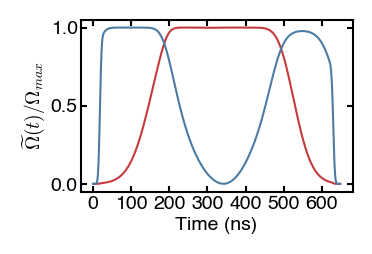

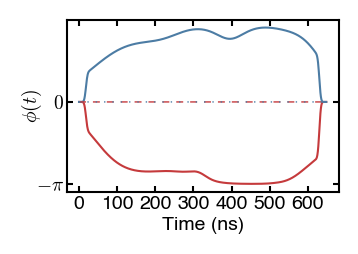

In [11]:
# Amplitude Plot
fig, ax = getStylishFigureAxes(1, 1)

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_i_amplitude,
    xlabel='Time (ns)',
    ylabel=r'$\widetilde{\Omega}(t)/\Omega_{max}$',
    style={'label': '$\Omega_1$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    xticks=[0, 100, 200, 300, 400, 500, 600],
    yticks=[0, 0.5, 1],
    ).draw()

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_r_amplitude,
    style={'label': '$\Omega_2$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},

    ).draw()

# automateAxisLimitsByTicks(ax)
plt.show()

# Phase Comparison Plot
fig, ax = getStylishFigureAxes(1, 1)

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_i_phase,
    xlabel='Time (ns)',
    ylabel=r'$\phi(t)$',
    style={'label': r'$\phi_1$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    xticks=[0, 100, 200, 300, 400, 500, 600],
    yticks = [-np.pi, 0, np.pi],
    ).draw()

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_r_phase,
    style={'label': r'$\phi_2$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()

dashed = (0, (5, 5))
dotted = (0, (1, 5))

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    np.zeros_like(tlist/1e-9),
    style={'label': r'$\phi_2^0$', 'linestyle': dashed, 'marker': '', 'color': '#c53a3c', 'alpha': 1},
    ).draw()

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    np.zeros_like(tlist/1e-9),
    style={'label': r'$\phi_1^0$', 'linestyle': dotted, 'marker': '', 'color': '#4c7ca4', 'alpha': 1},
    ).draw()

ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax.yaxis.labelpad = -3 # adjust spacing between y-axis label and ticks

# automateAxisLimitsByTicks(ax)
plt.show()


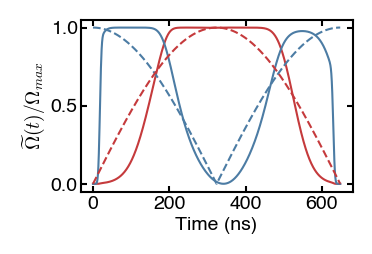

In [12]:
# Compare with analytical solution

def Rabi_1_analytical_adiabatic_cz(t, args):  # Rabi conncecting 1 to i
    return np.sin(np.pi / (2 * args['tau']) * t)


def Rabi_2_analytical_adiabatic_cz(t, args):  # Rabi conncecting i to r
    return abs(np.cos(np.pi / (2 * args['tau']) * t))

fig, ax = getStylishFigureAxes(1, 1)

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_i_amplitude,
    xlabel='Time (ns)',
    ylabel=r'$\widetilde{\Omega}(t)/\Omega_{max}$',
    style={'label': '$\Omega_1$', 'linewidth': 0.75, 'linestyle': '-', 'marker': ''},
    xticks=[0, 200, 400, 600],
    yticks=[0, 0.5, 1],
    ).draw()

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_r_amplitude,
    style={'label': '$\Omega_2$', 'linewidth': 0.75, 'linestyle': '-', 'marker': ''},
    ).draw()

# Add analytical solutions with dashed lines
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_2_analytical_adiabatic_cz(tlist, {'tau': t_f / 2}),
    style={'label': '$\Omega_2$ (analytical)', 'linewidth': 0.75, 'linestyle': '--', 'color': '#4c7ca4', 'marker': ''},
    ).draw()

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    Rabi_1_analytical_adiabatic_cz(tlist, {'tau': t_f / 2}),
    style={'label': '$\Omega_1$ (analytical)', 'linewidth': 0.75, 'linestyle': '--', 'color': '#c53a3c', 'marker': ''},
    ).draw()

# automateAxisLimitsByTicks(ax)
plt.show()


In [13]:
# State overlap calculations

# Find overlap of the dark state with the actual state over the evolution:
DS_overlap_squared = []
i_overlap_squared = []
rr_overlap_squared = []
plus_overlap_squared = []
targ_overlap_squared = []

state11_11_overlap_squared = []
state11_rr_overlap_squared = []
state11_i_overlap_squared = []
state11_DS_overlap_squared = []

#propagatorVL = data['propagatorVL'].item() # Removed .item()
dim = propagatorVL.dim
exps = propagatorVL.exponentials()
#physical_amplitudes_final = propagatorVL.return_physical_amplitudes().numpy() # Already calculated
g_0, g_1, i, r = propagatorVL.nLevelAtomBasis(propagatorVL.dim)
#dark = (Rabi_r * tensor(g_1, g_0) - Rabi_i * tensor(r, g_0))/(np.sqrt(Rabi_r**2 + Rabi_i**2))

# initialize current state:
current_state_pp = propagatorVL.psi_pp
current_state_10 = propagatorVL.psi_10
current_state_11 = propagatorVL.psi_11


for ind in range(propagatorVL.no_of_steps + 2 * propagatorVL.padding):

    # #Find the instantaneous dark state: initial state |10>
    # # (depends on the instantaneous Rabi frequencies)
    current_Rabi_i_real = propagatorVL.Rabi_i * physical_amplitudes_final[ind, 1] * \
        np.cos(np.pi * physical_amplitudes_final[ind, 2])
    current_Rabi_i_imag = propagatorVL.Rabi_i * physical_amplitudes_final[ind, 1] * \
        np.sin(np.pi * physical_amplitudes_final[ind, 2])
    current_Rabi_r_real = propagatorVL.Rabi_r * physical_amplitudes_final[ind, 3] * \
        np.cos(np.pi * physical_amplitudes_final[ind, 4])
    current_Rabi_r_imag = propagatorVL.Rabi_r * physical_amplitudes_final[ind, 3] * \
        np.sin(np.pi * physical_amplitudes_final[ind, 4])

    # Find dark state: D = Rabi_r |1> - Rabi_i* |r>
    norm_dark = 1 / np.sqrt(
        current_Rabi_i_real**2 + current_Rabi_i_imag**2
        + current_Rabi_r_real**2 + current_Rabi_r_imag**2
    )
    dark_state = norm_dark * (
        (current_Rabi_r_real + 1j * current_Rabi_r_imag) * tensor(g_1, g_0)
        - (current_Rabi_i_real - 1j * current_Rabi_i_imag) * tensor(r, g_0)
    )
    # Find overlap squared between current state and the dark state
    darkstate_overlap = tf.linalg.matmul(
        current_state_10, dark_state, adjoint_a=True
    )[0, 0]
    DS_overlap_squared.append(
        tf.math.real(tf.math.conj(darkstate_overlap) * darkstate_overlap)
    )
    # Find the state at time step i:
    current_state_10 = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_10
    )

    # For initial state |++>:
    # Find ++, target, and rr populations:
    plus = 1/np.sqrt(2) * (g_0 + g_1)
    plus_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(plus, plus), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    plus_overlap_squared.append(
        tf.math.real(tf.math.conj(plus_overlap) * plus_overlap)
    )

    targ_two_qubit = 1/2 * (tensor(g_0, g_0) + tensor(g_1, g_0) +
                            tensor(g_0, g_1) - tensor(g_1, g_1))
    targ_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(targ_two_qubit, dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    targ_overlap_squared.append(
        tf.math.real(tf.math.conj(targ_overlap) * targ_overlap)
    )

    rr_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(r, r), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    rr_overlap_squared.append(
        tf.math.real(tf.math.conj(rr_overlap) * rr_overlap)
    )
    i_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(i, identity(dim)), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    i_overlap_squared.append(
        tf.math.real(tf.math.conj(i_overlap) * i_overlap)
    )

    # Find the state at time step i:
    current_state_pp = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_pp
    )

    # For initial state |11>:
    # Find 11, and rr populations:
    state11_11_overlap = tf.linalg.matmul(
        current_state_11, tf.cast(tensor(g_1, g_1), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    state11_11_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_11_overlap) * state11_11_overlap)
    )

    state11_rr_overlap = tf.linalg.matmul(
        current_state_11, tf.cast(tensor(r, r), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    state11_rr_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_rr_overlap) * state11_rr_overlap)
    )
    state11_i_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(i, identity(dim)), dtype=tf.complex128), adjoint_a=True
    )[0, 0]
    state11_i_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_i_overlap) * state11_i_overlap)
    )

    state11_DS_overlap = tf.linalg.matmul(
        current_state_11, dark_state, adjoint_a=True
    )[0, 0]
    state11_DS_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_DS_overlap) * state11_DS_overlap)
    )
    # Find the state at time step i:
    current_state_11 = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_11
    )

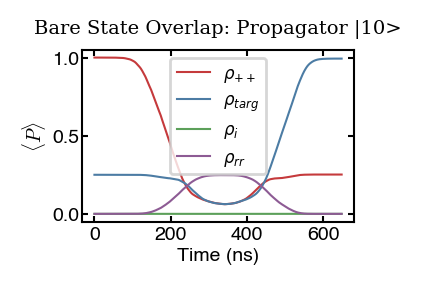

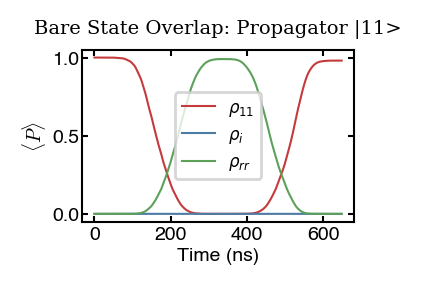

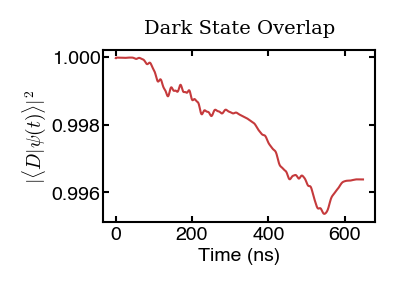

In [14]:
# Plot g, i, r populations
fig, ax = getStylishFigureAxes(1, 1)
xticks = [0, 200, 400, 600]

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    plus_overlap_squared,
    xlabel='Time (ns)',
    ylabel=r'$\langle P \rangle$',
    title='Bare State Overlap: Propagator |10>',
    style={'label': r'$\rho_{++}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    xticks=xticks,
    ).draw()
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    targ_overlap_squared,
    style={'label': r'$\rho_{targ}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    i_overlap_squared,
    style={'label': r'$\rho_{i}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    rr_overlap_squared,
    style={'label': r'$\rho_{rr}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()

ax.legend(fontsize=6)
plt.show()


# Plot g, i, r populations
fig, ax = getStylishFigureAxes(1, 1)
xticks = [0, 200, 400, 600]

PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    state11_11_overlap_squared,
    xlabel='Time (ns)',
    ylabel=r'$\langle P \rangle$',
    title='Bare State Overlap: Propagator |11>',
    style={'label': r'$\rho_{11}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    xticks=xticks,
    ).draw()
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    state11_i_overlap_squared,
    style={'label': r'$\rho_{i}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    state11_rr_overlap_squared,
    style={'label': r'$\rho_{rr}$', 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    ).draw()

ax.legend(fontsize=6)
plt.show()

# Plot dark state overlap throughout the pulse duration:
fig, ax = getStylishFigureAxes(1, 1)
xticks = [0, 200, 400, 600]
PlotPlotter(
    fig,
    ax,
    tlist/1e-9,
    DS_overlap_squared,
    xlabel='Time (ns)',
    ylabel=r'$|\langle D|\psi(t)\rangle|^2$',
    title='Dark State Overlap',
    style={ 'marker': '', 'linestyle': '-', 'linewidth': 0.75},
    xticks=xticks,
    ).draw()
plt.show()


In [15]:
# # Log scale for i-state overlap (|10> initial)
# fig, ax = getStylishFigureAxes(1, 1)
# ax.set_yscale('log')
# PlotPlotter(
#     fig,
#     ax,
#     tlist/1e-9,
#     i_overlap_squared,
#     xlabel='Time (ns)',
#     ylabel=r'$|\langle i|\psi(t)\rangle|^2$',
#     yticks=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1],
#     xticks=[0, 200, 400, 600],
#     ).draw()
# plt.show()

# # Log scale for i-state overlap (|11> initial)
# fig, ax = getStylishFigureAxes(1, 1)
# ax.set_yscale('log')
# PlotPlotter(
#     fig,
#     ax,
#     tlist/1e-9,
#     state11_i_overlap_squared,
#     xlabel='Time (ns)',
#     ylabel=r'|\langle i|\psi(t)\rangle|^2$',
#     yticks=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1],
#     xticks=[0, 200, 400, 600],
#     ).draw()
# plt.show()

# # Linear scale for rr-state overlap
# fig, ax = getStylishFigureAxes(1, 1)
# PlotPlotter(
#     fig,
#     ax,
#     tlist/1e-9,
#     rr_overlap_squared,
#     xlabel='Time (ns)',
#     ylabel=r'$|\langle rr|\psi(t)\rangle|^2$',
#     yticks=[0, 0.1, 0.2],
#     xticks=[0, 200, 400, 600],
#     ).draw()
# plt.show()
